# Reconhecimento de Padrões (TIP8311) - Trabalho 2


**Professor:** Guilherme de Alencar Barreto  

<img src="https://loop.frontiersin.org/images/profile/243428/203" alt="Foto do Professor" width="150"/>


**Aluno:** Luis Felipe Carneiro de Souza    **Matrícula:** 535049

In [1]:
import pandas as pd
import numpy as np
import time
from scipy.spatial.distance import minkowski
from sklearn.preprocessing import normalize
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm

In [2]:
paht_sensor_4 = "https://raw.githubusercontent.com/LuisFelipeCSouza/reconhecimento-de-padroes/refs/heads/main/trabalho-2/wall%2Bfollowing%2Brobot%2Bnavigation%2Bdata/sensor_readings_4.data"

path_sensor_24 = "https://raw.githubusercontent.com/LuisFelipeCSouza/reconhecimento-de-padroes/refs/heads/main/trabalho-2/wall%2Bfollowing%2Brobot%2Bnavigation%2Bdata/sensor_readings_24.data"

A flag `opt = 1` em *`cov(x, opt)`* normaliza com N

```octave
>> format long g
>> cov(X, 1)
ans =

 Columns 1 and 2:

      0.3926803582086445   -0.006142993532974544
   -0.006142993532974544      0.1173492953591072
     -0.0362831756885664    -0.03929951736012198
      -0.112023079916189     0.09336558416015139

 Columns 3 and 4:

     -0.0362831756885664      -0.112023079916189
    -0.03929951736012198     0.09336558416015139
      0.3163850369731714    -0.01816601865718874
    -0.01816601865718874      0.6751499405340027
```

In [3]:
M_ref = np.array([
    [ 0.3926803582086445,  -0.006142993532974544,  -0.0362831756885664,  -0.112023079916189 ],
    [ -0.006142993532974544,  0.1173492953591072,  -0.03929951736012198,   0.09336558416015139 ],
    [ -0.0362831756885664,  -0.03929951736012198,   0.3163850369731714,  -0.01816601865718874 ],
    [ -0.112023079916189,   0.09336558416015139,  -0.01816601865718874,   0.6751499405340027 ]
])
print(M_ref)

[[ 0.39268036 -0.00614299 -0.03628318 -0.11202308]
 [-0.00614299  0.1173493  -0.03929952  0.09336558]
 [-0.03628318 -0.03929952  0.31638504 -0.01816602]
 [-0.11202308  0.09336558 -0.01816602  0.67514994]]


In [4]:
data = np.genfromtxt(paht_sensor_4, delimiter=",", dtype=str, encoding="utf-8")

X = data[:, :-1].astype(float)  # todas menos a última coluna convertidas para float
y = data[:, -1]                 # última coluna como string

y = y.reshape(-1, 1)

X, y

(array([[1.687, 0.445, 2.332, 0.429],
        [1.687, 0.449, 2.332, 0.429],
        [1.687, 0.449, 2.334, 0.429],
        ...,
        [0.873, 0.642, 1.053, 1.105],
        [0.967, 0.635, 1.034, 1.118],
        [0.854, 0.628, 1.016, 1.168]]),
 array([['Slight-Right-Turn'],
        ['Slight-Right-Turn'],
        ['Slight-Right-Turn'],
        ...,
        ['Sharp-Right-Turn'],
        ['Move-Forward'],
        ['Sharp-Right-Turn']], dtype='<U17'))

## Q1.

Estimar a matriz de covariância GLOBAL (i.e. sem considerar os rótulos das classes) para o referido conjunto de dados usando os Métodos 1 a 4 descritos nos slides. Comparar como o resultado produzido pelo comando COV nativo Octave/Matlab ou de outra de programação de sua preferência. Para a comparação, calcular a norma da matriz de diferenças &E = C - C& em que C é matriz de covariância estimada pelos métodos implementados  C é a matrz

Método 1

In [5]:
def cov_1(X):
    p, N = X.shape
    soma = np.zeros((p, p))
    m = X.mean(axis=1).reshape(-1,1) # Vetor coluna
    for i in range(N):
        aux = X[:, i].reshape(-1, 1) - m
        soma += aux @ aux.T
    C = soma / N
    return C

In [7]:
cov_1(X.T)

array([[ 0.39268036, -0.00614299, -0.03628318, -0.11202308],
       [-0.00614299,  0.1173493 , -0.03929952,  0.09336558],
       [-0.03628318, -0.03929952,  0.31638504, -0.01816602],
       [-0.11202308,  0.09336558, -0.01816602,  0.67514994]])

Método 2

In [6]:
def cov_2(X):
    p, N = X.shape
    m = X.mean(axis=1).reshape(-1,1) # Vetor coluna
    aux = X - m
    return (aux @ aux.T) / N

In [9]:
cov_2(X.T)

array([[ 0.39268036, -0.00614299, -0.03628318, -0.11202308],
       [-0.00614299,  0.1173493 , -0.03929952,  0.09336558],
       [-0.03628318, -0.03929952,  0.31638504, -0.01816602],
       [-0.11202308,  0.09336558, -0.01816602,  0.67514994]])

Método 3

In [7]:
def cov_3(X):
    p, N = X.shape
    R = np.zeros((p, p))
    m = X.mean(axis=1).reshape(-1,1)
    for i in range(N):
        R += X[:, i].reshape(-1, 1) @ X[:, i].reshape(-1, 1).T

    C = (R / N) - (m @ m.T)
    return C

In [11]:
cov_3(X.T)

array([[ 0.39268036, -0.00614299, -0.03628318, -0.11202308],
       [-0.00614299,  0.1173493 , -0.03929952,  0.09336558],
       [-0.03628318, -0.03929952,  0.31638504, -0.01816602],
       [-0.11202308,  0.09336558, -0.01816602,  0.67514994]])

Método 4

In [8]:
def cov_4(X):
    p, N = X.shape
    m = X.mean(axis=1).reshape(-1,1)
    R = (X @ X.T) / N
    C = R - (m @ m.T)
    return C

In [13]:
cov_4(X.T)

array([[ 0.39268036, -0.00614299, -0.03628318, -0.11202308],
       [-0.00614299,  0.1173493 , -0.03929952,  0.09336558],
       [-0.03628318, -0.03929952,  0.31638504, -0.01816602],
       [-0.11202308,  0.09336558, -0.01816602,  0.67514994]])

## Questão 02

Comparar (de modo cientficamente correto!) os métodos implementados no Item 1 com o comando COV nativo do Octave/Matlab ou de outra linguagem de programação que melhor lhe convier em termos de tempo médio de execução. No Matlab/Octave usar os comandos tic/toc. Para isso, execute cada método por 100 rodadas, guardando o tempo de execução de cada método em cada rodada. Ao final das 100 rodadas, compare os gráficos do histograma e do violin plot1 do tempo de execução de cada método. Compare-os também numericamente em termos de tempo de execução médio e desvio-padrão. Comente os resultados obtidos.

In [9]:
import time

# Supondo que você já tenha definido suas funções:
# def cov_1(X): ...
# def cov_2(X): ...
# def cov_3(X): ...
# def cov_4(X): ...

def simu(X, funcs, n_iter=100):
    """
    Executa n_iter rodadas de cálculo da matriz de covariância
    para cada função em funcs e retorna listas de tempos.
    
    X: matriz de entrada
    funcs: lista de funções [cov_1, cov_2, cov_3, cov_4]
    n_iter: número de repetições
    """
    tempos = [[] for _ in funcs]  # cria uma lista de listas

    for i, f in enumerate(funcs):
        for _ in range(n_iter):
            inicio = time.perf_counter()
            f(X.T)   # executa a função
            fim = time.perf_counter()
            tempos[i].append(fim - inicio)

    return tempos

# Exemplo de uso:
funcs = [cov_1, cov_2, cov_3, cov_4]
temp_cov_1, temp_cov_2, temp_cov_3, temp_cov_4 = simu(X, funcs, n_iter=100)

# tempos[0] = lista de tempos do cov_1
# tempos[1] = lista de tempos do cov_2
# etc.
temp_cov_1, temp_cov_2, temp_cov_3, temp_cov_4


([0.03703620005398989,
  0.03270959993824363,
  0.024232499999925494,
  0.02059259987436235,
  0.021299699787050486,
  0.02052180003374815,
  0.022165799979120493,
  0.021687500178813934,
  0.021844200091436505,
  0.023652799893170595,
  0.02014260017313063,
  0.020425499882549047,
  0.026595500065013766,
  0.030680299969390035,
  0.02566409995779395,
  0.02733700000680983,
  0.021810299949720502,
  0.020681000081822276,
  0.021343400003388524,
  0.02095280005596578,
  0.020802099956199527,
  0.021793300053104758,
  0.023623300017789006,
  0.02155559998936951,
  0.022474100114777684,
  0.022262200014665723,
  0.02408830006606877,
  0.032769199926406145,
  0.03130310005508363,
  0.026580799836665392,
  0.025993800023570657,
  0.037233500042930245,
  0.02530750003643334,
  0.026032600086182356,
  0.026005000108852983,
  0.029039900051429868,
  0.027543399948626757,
  0.026446899864822626,
  0.028905800078064203,
  0.033646800089627504,
  0.030586499953642488,
  0.031216199975460768,
  0.

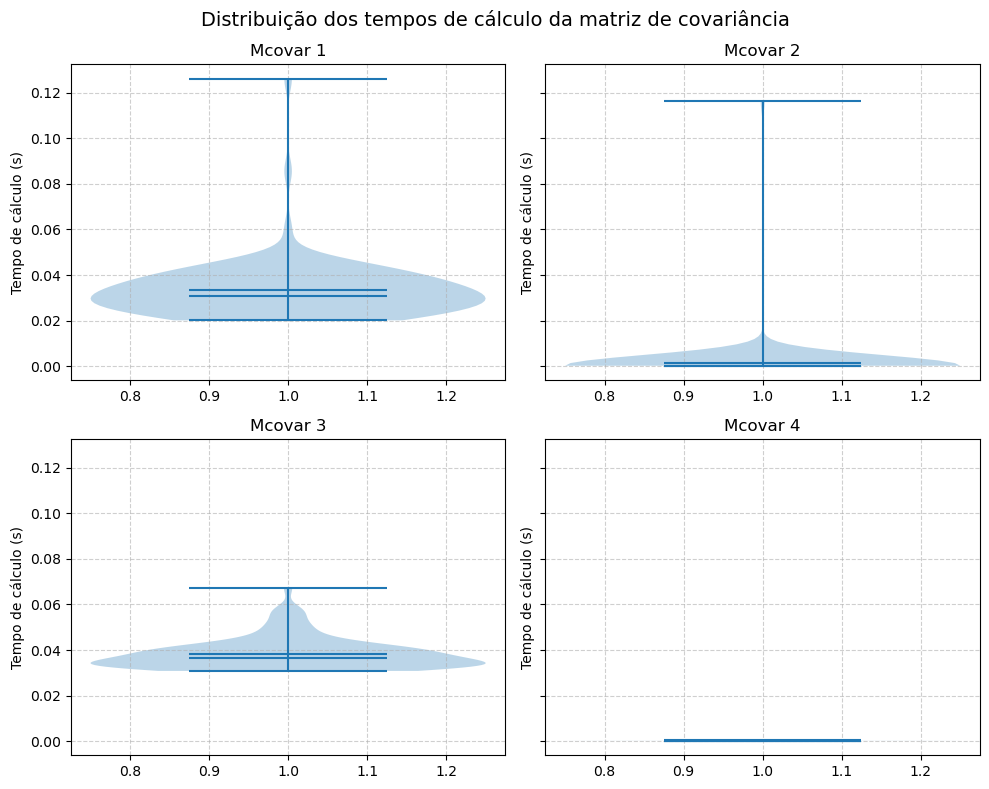

In [10]:
import matplotlib.pyplot as plt

# Supondo que você já tenha as listas:
# temp_cov_1 = [...]
# temp_cov_2 = [...]
# temp_cov_3 = [...]
# temp_cov_4 = [...]

data = [temp_cov_1, temp_cov_2, temp_cov_3, temp_cov_4]
labels = ["Mcovar 1", "Mcovar 2", "Mcovar 3", "Mcovar 4"]

fig, axes = plt.subplots(2, 2, figsize=(10,8), sharey=True)  # 2 linhas, 2 colunas
axes = axes.flatten()  # transformar em lista para iterar

for i, ax in enumerate(axes):
    ax.violinplot(data[i], showmeans=True, showmedians=True)
    ax.set_title(labels[i])
    ax.set_ylabel("Tempo de cálculo (s)")
    ax.grid(True, linestyle="--", alpha=0.6)

plt.suptitle("Distribuição dos tempos de cálculo da matriz de covariância", fontsize=14)
plt.tight_layout()
plt.show()


## Questão 03

Escolher o método mais rápido no Item 1 e estimar as matrizes de covariância de cada classe, avaliando suas invertibilidades comparando com a invertibilidade da matriz de covariância global através do posto e do número de condicionamento. No Matlab/Octave usar comandos rank e rcond. As matrizes em questão são invertíveis e numericamente bem-condicionadas?

In [22]:
X[:10, :]

array([[1.687, 0.445, 2.332, 0.429],
       [1.687, 0.449, 2.332, 0.429],
       [1.687, 0.449, 2.334, 0.429],
       [1.687, 0.449, 2.334, 0.429],
       [1.687, 0.449, 2.334, 0.429],
       [1.686, 0.446, 2.334, 0.43 ],
       [1.684, 0.451, 2.33 , 0.432],
       [1.68 , 0.453, 2.327, 0.436],
       [0.753, 0.457, 2.323, 0.442],
       [0.744, 0.462, 2.321, 0.449]])

In [11]:
np.unique(y, return_counts=True)

m_cov_class = []

for i in np.unique(y):
    mask = np.where(y == i)[0] # mascara dos indices
    # print((np.where(y == i))[0])
    # print(X[(np.where(y == i))[0], :])

    y_class = y[mask]
    X_class = X[mask, :]
    print(f"Classe: {i}, Matriz de covariância:")
    mcov = cov_4(X_class.T)
    m_cov_class.append((i, mcov))
    print(mcov, '\n')

Classe: Move-Forward, Matriz de covariância:
[[ 0.4677022  -0.00162651 -0.0646883  -0.11122701]
 [-0.00162651  0.00897263 -0.00546328  0.00755037]
 [-0.0646883  -0.00546328  0.28296953  0.04786369]
 [-0.11122701  0.00755037  0.04786369  0.34130193]] 

Classe: Sharp-Right-Turn, Matriz de covariância:
[[ 5.39462607e-03  4.23760936e-04 -6.83570516e-03 -4.25721561e-03]
 [ 4.23760936e-04  1.09053004e-01 -4.92398242e-02  8.22374161e-02]
 [-6.83570516e-03 -4.92398242e-02  4.48505192e-01 -5.39085397e-02]
 [-4.25721561e-03  8.22374161e-02 -5.39085397e-02  1.12071643e+00]] 

Classe: Slight-Left-Turn, Matriz de covariância:
[[ 0.10489945 -0.00764646  0.06755705 -0.0885949 ]
 [-0.00764646  0.27480251 -0.02828925  0.03960111]
 [ 0.06755705 -0.02828925  0.09801354 -0.06412424]
 [-0.0885949   0.03960111 -0.06412424  0.20613506]] 

Classe: Slight-Right-Turn, Matriz de covariância:
[[ 0.2812897  -0.00223476 -0.03581292 -0.00799291]
 [-0.00223476  0.00160667 -0.00519406  0.00123762]
 [-0.03581292 -0.005

In [24]:
for c, m in m_cov_class:
    print(f"A matriz do covariância da classe {c} apresenta posto {np.linalg.matrix_rank(m)}")

A matriz do covariância da classe Move-Forward apresenta posto 4
A matriz do covariância da classe Sharp-Right-Turn apresenta posto 4
A matriz do covariância da classe Slight-Left-Turn apresenta posto 4
A matriz do covariância da classe Slight-Right-Turn apresenta posto 4


In [26]:
for c, m in m_cov_class:
    print(f"A matriz do covariância da classe {c} apresenta número de condicionamento {np.linalg.cond(m):.3f}")

A matriz do covariância da classe Move-Forward apresenta número de condicionamento 64.337
A matriz do covariância da classe Sharp-Right-Turn apresenta número de condicionamento 215.018
A matriz do covariância da classe Slight-Left-Turn apresenta número de condicionamento 11.112
A matriz do covariância da classe Slight-Right-Turn apresenta número de condicionamento 218.673


## Questão 04

Inverter as matrizes de covariância global e de cada classe individualmente. OBS: Se houver problema de inversão destas matrizes, use alguma técnica de regularização discutidas em sala de aula.

In [34]:
for c, m in m_cov_class:
    print(f"Inversa da matriz de covariância da classe {c}")
    print(np.linalg.inv(m), "\n")

Inversa da matriz de covariância da classe Move-Forward
[[ 2.36563735e+00  8.88333720e-02  4.22463105e-01  7.09727631e-01]
 [ 8.88333720e-02  1.15588595e+02  2.74470739e+00 -2.91304576e+00]
 [ 4.22463105e-01  2.74470739e+00  3.75968511e+00 -4.50295309e-01]
 [ 7.09727631e-01 -2.91304576e+00 -4.50295309e-01  3.28884242e+00]] 

Inversa da matriz de covariância da classe Sharp-Right-Turn
[[ 1.89851022e+02 -4.08267190e-02  2.99340280e+00  8.68162695e-01]
 [-4.08267190e-02  1.01605750e+01  1.03120004e+00 -6.96128598e-01]
 [ 2.99340280e+00  1.03120004e+00  2.39457944e+00  5.08858562e-02]
 [ 8.68162695e-01 -6.96128598e-01  5.08858562e-02  9.49113379e-01]] 

Inversa da matriz de covariância da classe Slight-Left-Turn
[[ 22.14255881  -1.47288851 -11.64605731   6.17678168]
 [ -1.47288851   3.88689248   1.54978869  -0.89764765]
 [-11.64605731   1.54978869  19.09360192   0.6365148 ]
 [  6.17678168  -0.89764765   0.6365148    7.87636626]] 

Inversa da matriz de covariância da classe Slight-Right-Tur

In [35]:
for c, m in m_cov_class:
    print(f"Inversa da matriz de covariância da classe {c}")
    print(np.linalg.inv(m+(np.eye(4) * 1e-4)), "\n")

Inversa da matriz de covariância da classe Move-Forward
[[ 2.36500891e+00  8.78872446e-02  4.22212273e-01  7.09371093e-01]
 [ 8.78872446e-02  1.14266224e+02  2.71219161e+00 -2.87869684e+00]
 [ 4.22212273e-01  2.71219161e+00  3.75748993e+00 -4.49218262e-01]
 [ 7.09371093e-01 -2.87869684e+00 -4.49218262e-01  3.28685227e+00]] 

Inversa da matriz de covariância da classe Sharp-Right-Turn
[[ 1.86312900e+02 -4.02687028e-02  2.93692839e+00  8.51889102e-01]
 [-4.02687028e-02  1.01501071e+01  1.02992233e+00 -6.95357768e-01]
 [ 2.93692839e+00  1.02992233e+00  2.39302080e+00  5.06855911e-02]
 [ 8.51889102e-01 -6.95357768e-01  5.06855911e-02  9.48900696e-01]] 

Inversa da matriz de covariância da classe Slight-Left-Turn
[[ 22.07614879  -1.46671649 -11.59836655   6.15890134]
 [ -1.46671649   3.88484667   1.54458632  -0.89578573]
 [-11.59836655   1.54458632  19.04345334   0.64209963]
 [  6.15890134  -0.89578573   0.64209963   7.86624502]] 

Inversa da matriz de covariância da classe Slight-Right-Tur

In [31]:
np.eye(3) * 1e-6

array([[1.e-06, 0.e+00, 0.e+00],
       [0.e+00, 1.e-06, 0.e+00],
       [0.e+00, 0.e+00, 1.e-06]])